#### thankGOD! this code should be run in the tf_env of conda and can not be run in base enviroment of conda thankGOD!

here we use NN to predict the saturated concentration of IDPs from 362 simulation data set of Keresten. We test the model on a 26 experimental samples and a 15 exp samples.

In [253]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
import random
import tensorflow as tf
from tensorflow.keras.backend import clear_session

In [254]:
%cd /media/saeed/Expansion/ASU/md-intro-tutorial/ml_project/Keresten/data/phase_separation/

/media/saeed/Expansion/ASU/md-intro-tutorial/ml_project/Keresten/data/phase_separation


### Define the main data set: 363 simul deta set of Keresten for Cs

In [255]:
import pandas as pd

# Load the CSV file
file_path = 'df_training.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Specify the column name you want to display
column_name = 'logcdil_mgml'  # Replace with your actual column name

# Display the column
if column_name in data.columns:
    print(data[column_name])
else:
    print(f"Column '{column_name}' not found in the CSV file.")

0      4.398460
1      0.710698
2      4.429244
3     -3.159101
4      0.264526
         ...   
357    3.326443
358    2.041110
359   -2.070955
360   -1.119822
361   -0.091593
Name: logcdil_mgml, Length: 362, dtype: float64


In [256]:
print (data.columns)

Index(['seq_name', 'id', 'UniProt_ID', 'N', 'nu', 'SPR', 'ete2_Rg2', 'S',
       'Delta', 'Rg/nm', 'Ree/nm', 'Rh/nm', 'fK', 'fR', 'fE', 'fD', 'faro',
       'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'ncpr', 'fasta',
       'is_btw_folded', 'is_nterm', 'is_cterm', 'is_idp', 'first', 'last',
       'N_FL', 'protein_name', 'gene_name', 'QCDpred', 'z_delta_+-',
       'z_omega_pi', 'z_omega_+', 'z_omega_-', 'fdomain', 'nu_svr', 'SPR_svr',
       'mw', 'nframes', 'cdil', 'cden', 'edil', 'eden', 'dG', 'dG_error',
       'logcdil', 'cdil_mgml', 'logcdil_mgml', 'log10cdil_mgml', 'ah_ij',
       'Frequency/ns'],
      dtype='object')


### since there is some missing in data points of df_training(10 features of 35 protein sample) !!!!
I have to clean the data frame 

In [257]:
# Replace 'your_file.csv' with the path to your CSV file
#df = pd.read_csv('IDRome_DB.csv', usecols=['Rg/nm','N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD',	'faro','kappa','fcr'])
df = pd.read_csv('df_training.csv', usecols=['logcdil_mgml', 'nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij'])
#ah_ij is delta H pair

#since there is some missing in data points of df_training(10 features of 35 protein sample) !!!!
# I have to clean the data frame 
df_cleaned = df.dropna()
#df_cleaned = pd.DataFrame(df.dropna(), columns = df.columns) 

# Separate the target (Cs or cdil) and features
X_large = df_cleaned .drop(columns=['logcdil_mgml'])  # Features (all columns except 'Rg')
y_large= df_cleaned ['logcdil_mgml']  # Target (only the 'Rg' column)


print(X_large.shape,'', y_large.shape)

(362, 8)  (362,)


In [258]:
X_large

,faro,mean_lambda,shd,scd,fcr,ncpr,nu_svr,ah_ij
0,0.200000,0.566454,3.596119,-0.196371,0.114286,-0.057143,0.505861,-0.827833
1,0.057221,0.474260,5.190868,12.793575,0.332425,0.092643,0.476007,-0.682819
2,0.044586,0.472080,4.394302,1.761347,0.312102,0.121019,0.498899,-0.715692
3,0.054978,0.418331,5.113843,-18.405372,0.341753,0.035661,0.312179,-0.630739
4,0.024752,0.349329,3.422490,-13.790708,0.465347,0.014851,0.184191,-0.568988
...,...,...,...,...,...,...,...,...
357,0.103286,0.465619,4.609359,0.841708,0.131455,-0.037559,0.516910,-0.644657
358,0.090909,0.507019,4.456303,-2.525388,0.173554,0.008264,0.453679,-0.674667
359,0.162162,0.588311,5.062414,-1.505927,0.270270,0.018018,0.432826,-0.806406
360,0.105263,0.480744,4.503688,-4.105873,0.245614,0.000000,0.412539,-0.680480


### combine the 27 samples of IDRome 90 with the whole 363 samples of training

In [259]:
# Replace 'your_file.csv' with the path to your CSV file
#df = pd.read_csv('IDRome_DB.csv', usecols=['Rg/nm','N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD',	'faro','kappa','fcr'])
df = pd.read_csv('df_validation_IDRome90.csv', usecols=['logcdil_mgml', 'nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij'])
#ah_ij is delta H pair

#since there is some missing in data points of df_training(10 features of 35 protein sample) !!!!
# I have to clean the data frame 
#df_cleaned = df.dropna()


# Separate the target (Cs or cdil) and features
X_IDRome90 = df .drop(columns=['logcdil_mgml'])  # Features (all columns except 'Rg')
y_IDRome90= df ['logcdil_mgml']  # Target (only the 'Rg' column)


print(X_IDRome90.shape,'', y_IDRome90.shape)

(27, 8)  (27,)


In [260]:
X_IDRome90

,faro,mean_lambda,shd,scd,fcr,ncpr,nu_svr,ah_ij
0,0.189655,0.519263,3.749571,-0.382484,0.224138,-0.017241,0.517067,-0.840159
1,0.068096,0.480652,6.001870,2.666349,0.137453,-0.023960,0.491663,-0.704467
2,0.032258,0.492520,4.536132,-0.045457,0.212903,0.032258,0.499753,-0.696398
3,0.117021,0.535682,4.450008,0.288881,0.127660,0.063830,0.498755,-0.855700
4,0.153333,0.497809,4.584490,0.086617,0.200000,0.026667,0.499764,-0.780410
5,0.000000,0.392607,2.420159,-0.623332,0.294118,0.000000,0.552927,-0.576657
6,0.114286,0.451610,4.722634,-1.977967,0.232143,-0.003571,0.487126,-0.681920
7,0.062762,0.405978,4.076994,-1.384472,0.376569,0.033473,0.496879,-0.641689
8,0.006849,0.465109,4.240682,3.270664,0.095890,0.082192,0.545802,-0.590513
9,0.064677,0.456235,5.070634,-2.611528,0.226368,-0.002488,0.468910,-0.701719


In [261]:
# to combine two data sets
X_total= np.concatenate ((X_IDRome90,X_large), axis=0)
y_total= np.concatenate ((y_IDRome90,y_large), axis=0)
X_total.shape
y_total.shape

(389,)

### read the 26 samples of IDRome 10 for final test of our model

In [262]:
# Replace 'your_file.csv' with the path to your CSV file
#df = pd.read_csv('IDRome_DB.csv', usecols=['Rg/nm','N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD',	'faro','kappa','fcr'])
df = pd.read_csv('df_validation_IDRome10.csv', usecols=['logcdil_mgml', 'nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij'])
#ah_ij is delta H pair

#since there is some missing in data points of df_training(10 features of 35 protein sample) !!!!
# I have to clean the data frame 
#df_cleaned = df.dropna()


# Separate the target (Cs or cdil) and features
X_IDRome10 = df .drop(columns=['logcdil_mgml'])  # Features (all columns except 'Rg')
y_IDRome10= df ['logcdil_mgml']  # Target (only the 'Rg' column)


print(X_IDRome10.shape,'', y_IDRome10.shape)

(26, 8)  (26,)


In [263]:
#print (type(X_IDRome10))
X_IDRome10

,faro,mean_lambda,shd,scd,fcr,ncpr,nu_svr,ah_ij
0,0.095890,0.447709,4.456860,-1.191078,0.182648,0.045662,0.500919,-0.675719
1,0.067851,0.427775,5.149692,-4.687216,0.252019,0.016155,0.455674,-0.647124
2,0.101887,0.476823,4.955896,-0.713291,0.139623,0.003774,0.497637,-0.674586
3,0.112069,0.490212,4.274722,-0.541513,0.250000,0.043103,0.501840,-0.710999
4,0.099010,0.573157,5.665236,-0.782310,0.094059,0.034653,0.460564,-0.670689
5,0.057692,0.583424,6.250992,0.536274,0.025641,0.019231,0.470063,-0.596440
6,0.081433,0.445602,4.727641,0.166962,0.224756,-0.022801,0.501966,-0.685216
7,0.065217,0.469716,4.721854,-1.362364,0.191304,0.013043,0.494813,-0.684952
8,0.099644,0.447916,4.674340,-0.206872,0.263345,0.014235,0.498218,-0.677299
9,0.115591,0.427414,4.674078,-0.278349,0.284946,0.013441,0.499143,-0.692854


### read the 15 experimental samples of df_prots_ORE.csv

In [264]:
# Replace 'your_file.csv' with the path to your CSV file
#df = pd.read_csv('IDRome_DB.csv', usecols=['Rg/nm','N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD',	'faro','kappa','fcr'])
df = pd.read_csv('df_prots_ORE.csv', usecols=['exp_logcdil_mgml', 'nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij'])
#ah_ij is delta H pair

#since there is some missing in data points of df_training(10 features of 35 protein sample) !!!!
# I have to clean the data frame 
df_cleaned = df.dropna()
#df_cleaned = pd.DataFrame(df.dropna(), columns = df.columns) 


# Separate the target (Cs or cdil) and features
X_exp = df_cleaned .drop(columns=['exp_logcdil_mgml']) # Features (all columns except 'Rg')
y_exp= df_cleaned ['exp_logcdil_mgml']  # Target (only the 'Rg' column)


print(X_exp.shape,'', y_exp.shape)

(15, 8)  (15,)


In [265]:
#print (type(X_exp))
X_exp

,faro,mean_lambda,shd,scd,fcr,ncpr,nu_svr,ah_ij
0,0.138686,0.661670,5.950235,1.336890,0.131387,0.058394,0.456722,-0.750163
1,0.138686,0.646384,5.811498,1.336890,0.131387,0.058394,0.463179,-0.719579
2,0.138686,0.652016,5.863002,1.336890,0.131387,0.058394,0.460802,-0.730826
3,0.138686,0.593400,5.344004,1.336890,0.131387,0.058394,0.484254,-0.726486
4,0.068182,0.549796,5.262886,-0.457383,0.267045,0.017045,0.464371,-0.689269
5,0.066265,0.547445,5.180159,-0.472984,0.271084,0.006024,0.466955,-0.677828
6,0.068182,0.549796,5.236905,-4.462347,0.267045,0.017045,0.348670,-0.689269
7,0.137405,0.613872,5.477135,1.846394,0.129771,0.068702,0.485602,-0.732918
8,0.138686,0.575638,5.182026,1.336890,0.131387,0.058394,0.491101,-0.724463
9,0.138686,0.557876,5.018406,1.336890,0.131387,0.058394,0.497798,-0.722112


# NN model for Cs

### Step 2: Preprocess the Data

Neural networks work better when the data is standardized (scaled to have a mean of 0 and standard deviation of 1).

In [266]:
#Clear the Session: If you’re running the script multiple times in the same session (e.g., in Jupyter), 
#clear TensorFlow's computational graph between runs to avoid accumulation:

clear_session()


In [267]:

# Set random seed for reproducibility. Always will get same result. but if I do not use it, every time that I run I got slightly different results
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


##### train on the total samples (362+27)

In [268]:
from sklearn.model_selection import train_test_split



# Step 1: Split the whole data set into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

# Step 2: Further split the training/validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Print sizes of each set
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Apply the same scaler to the smaller 64-sample dataset
X_test = scaler.transform(X_test)

#thankGOD! 


Training set: (248, 8), Validation set: (63, 8), Test set: (78, 8)


### Step 3: Define the Neural Network Model

We’ll create a small neural network with a couple of hidden layers and use dropout for regularization.

In [269]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


# Initialize the model
model = Sequential()

# Input layer and first hidden layer with 64 neurons and ReLU activation
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='elu'))
#model.add(Dense(64, input_shape=(X_train.shape[1],), activation='sigmoid'))
model.add(Dropout(0.01))  # Dropout layer to prevent overfitting
#model.add(kernel_regularizer=l2(0.01))

# Second hidden layer with 32 neurons
model.add(Dense(32, activation='elu'))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))

# Second hidden layer with 32 neurons
model.add(Dense(8, activation='elu'))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))

# third hidden layer with 32 neurons
model.add(Dense(8, activation='elu'))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))

# third hidden layer with 32 neurons
model.add(Dense(8, activation='elu'))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))

# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

### Step 4: Train the Model

We’ll use the training data and monitor performance on the validation set.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=20,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Fit the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=170,
    callbacks=[early_stopping],  # Add the callback here
    verbose=1
)

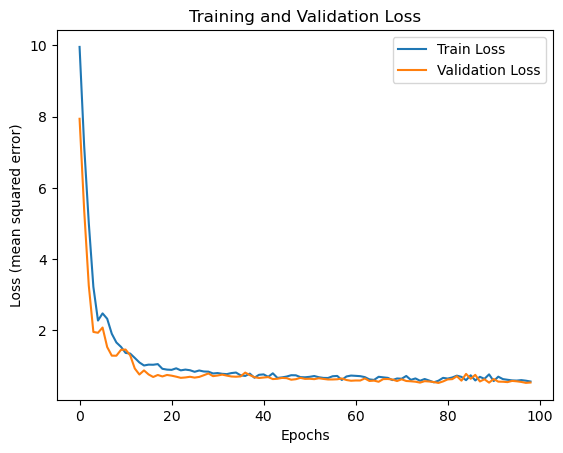

In [271]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (mean squared error)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [272]:
import joblib
# to save the trained model
joblib.dump(model, 'NN_model.joblib')

['NN_model.joblib']

### Step 5: Evaluate the Model on the test set

After training, you can evaluate the model on your test set.

In [273]:

# Predict on the 64-sample dataset
y_pred_nn = model.predict(X_test)
#y_pred_nn = model.predict(X_test_tensor)


# to calc RMSD we need 1D of y_pred_nn
y_pred_nn_1d = y_pred_nn.reshape(-1)

mse_nn = mean_squared_error(y_test, y_pred_nn_1d)
r2_nn = r2_score(y_test, y_pred_nn_1d)
# thankGOD! correct formula for RMSD
rmsd_nn=np.sqrt(((y_test - y_pred_nn_1d)**2).mean())


print("Neural Network MSE on test dataset:", mse_nn)
print("Neural Network R-squared on test dataset:", r2_nn)
print("Neural Network RMSD on test dataset:", rmsd_nn)

3/3 [==============================] - 0s 705us/step
Neural Network MSE on test dataset: 0.6057751312451601
Neural Network R-squared on test dataset: 0.880526835623199
Neural Network RMSD on test dataset: 0.7783155730455097


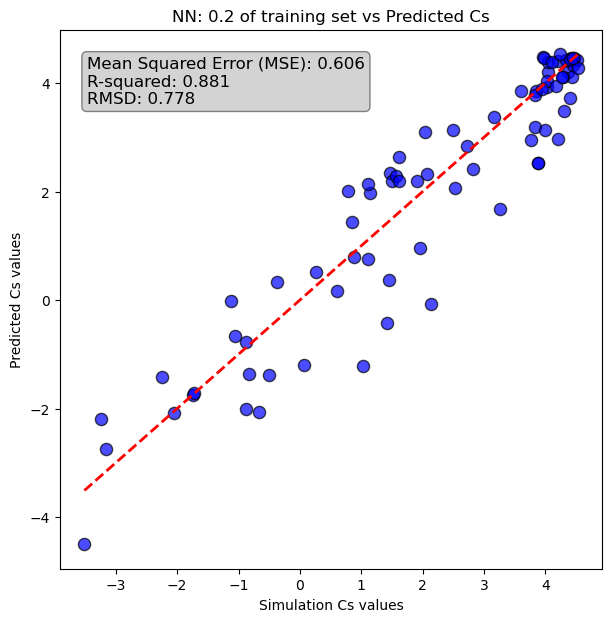

In [22]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_nn, color='blue', edgecolor='k', alpha=0.7, s=77)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Simulation Cs values')
plt.ylabel('Predicted Cs values')
plt.title('NN: 0.2 of training set vs Predicted Cs')

# Display MSE and R-squared inside the plot
text_str = f'Mean Squared Error (MSE): {mse_nn:.3f}\nR-squared: {r2_nn:.3f}\nRMSD: {rmsd_nn:.3f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'))

plt.show()

      nu_svr      faro  mean_lambda       shd       scd       fcr      ncpr  \
0  -1.112697 -1.946912    -1.875482  2.229797  1.259736 -2.565111  1.818652   
1   1.976163  1.564024     0.609643 -0.202420 -1.519030  0.257060  0.072594   
2  -0.568809  0.983638     0.264749 -0.220674 -1.323084  0.006337  0.169344   
3  -0.945030 -0.158542     0.061276 -0.358488 -0.554281 -0.057725 -0.455605   
4   0.671351  0.200589     0.300573 -0.238870 -0.190220 -0.065653  0.221921   
..       ...       ...          ...       ...       ...       ...       ...   
73  0.501239  0.727062     0.074327 -0.194101 -1.052589  0.470442  0.366180   
74 -0.296085 -0.533766    -0.354016 -0.213738  0.727731  0.297176  0.402648   
75 -0.120305  0.193577     1.302758  0.349334 -0.584191  0.467808  0.304287   
76 -0.231419  1.682609     0.840740  0.031020 -0.276488  1.298957  0.715206   
77  0.011081 -0.766158    -0.966621  0.367903  0.978786  1.581718  1.106263   

       ah_ij  
0   1.957151  
1  -1.276372  
2   0.

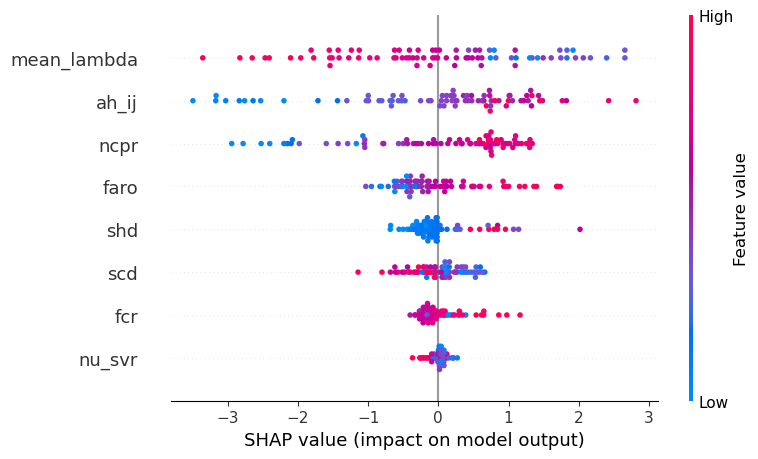

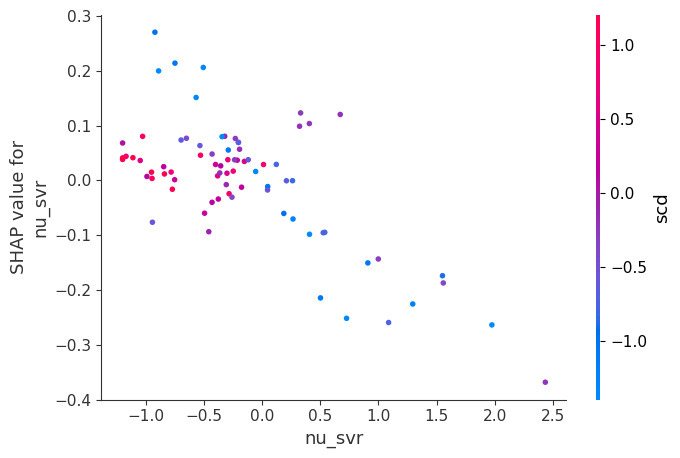

In [23]:
# find relationship of features and the whole 137 samples (delta_Rg)
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Extract feature names 
feature_names = ['nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij']  
X_test_df = pd.DataFrame(X_test, columns=feature_names)# Convert to DataFrame for better handling
print(X_test_df)
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_test_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)

###  Evaluate the Model on the whole data set

After training, you can evaluate the model on your test set.

In [274]:
# Apply the same scaler to the smaller 64-sample dataset
X_total = scaler.transform(X_total)

In [275]:
import joblib

# Predict on the 64-sample dataset
y_pred_nn = model.predict(X_total)
#y_pred_nn = model.predict(X_test_tensor)



# Calculate MSE and R-squared for dataset

# to calc RMSD we need 1D of y_pred_nn
y_pred_nn_1d = y_pred_nn.reshape(-1)

mse_nn = mean_squared_error(y_total, y_pred_nn_1d)
r2_nn = r2_score(y_total, y_pred_nn_1d)
# thankGOD! correct formula for RMSD
rmsd_nn=np.sqrt(((y_total - y_pred_nn_1d)**2).mean())


print("Neural Network MSE on test dataset:", mse_nn)
print("Neural Network R-squared on test dataset:", r2_nn)
print("Neural Network RMSD on test dataset:", rmsd_nn)

13/13 [==============================] - 0s 313us/step
Neural Network MSE on test dataset: 0.5205519030942065
Neural Network R-squared on test dataset: 0.9124505455351815
Neural Network RMSD on test dataset: 0.7214928295514839


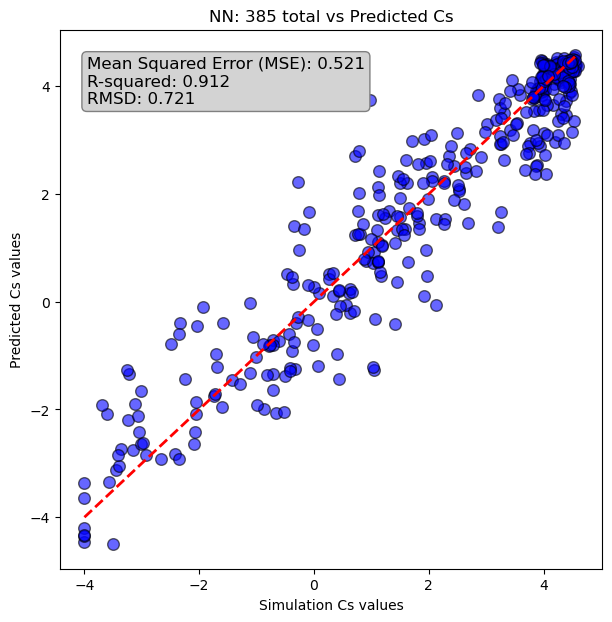

In [25]:
plt.figure(figsize=(7, 7))
plt.scatter(y_total, y_pred_nn, color='blue', edgecolor='k', alpha=0.6, s=70)
plt.plot([y_total.min(), y_total.max()], [y_total.min(), y_total.max()], 'r--', lw=2)
plt.xlabel('Simulation Cs values')
plt.ylabel('Predicted Cs values')
plt.title('NN: 385 total vs Predicted Cs')

# Display MSE and R-squared inside the plot
text_str = f'Mean Squared Error (MSE): {mse_nn:.3f}\nR-squared: {r2_nn:.3f}\nRMSD: {rmsd_nn:.3f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'))

plt.show()

       nu_svr      faro  mean_lambda       shd       scd       fcr      ncpr  \
0    1.558060  0.573616    -0.563171 -0.218543 -0.411436 -0.119025  0.566066   
1   -0.210624  0.212762     1.486744 -0.107547 -0.987508 -0.167874  0.288770   
2   -0.732063  0.323673     0.152713 -0.206273 -0.486097  0.240885  0.377077   
3    0.501239  0.727062     0.074327 -0.194101 -1.052589  0.470442  0.366180   
4    1.029578  0.373111     0.196726 -0.201465 -0.571846  0.200230  0.377193   
..        ...       ...          ...       ...       ...       ...       ...   
384  0.301397  0.072258     0.219360 -0.173975 -1.027364 -0.266752  0.564362   
385  0.121308  0.459185     0.080056 -0.296557 -0.747597  0.066427 -0.125856   
386  1.158038  1.218938     0.631704 -0.259443 -0.104861  0.137345 -0.353484   
387  0.330159  0.213619     0.123184 -0.354097 -0.268715  0.006337 -0.574932   
388  0.385853  0.460302    -0.033691 -0.216997 -0.028118  0.204636  0.254379   

        ah_ij  
0   -1.117329  
1   -0.

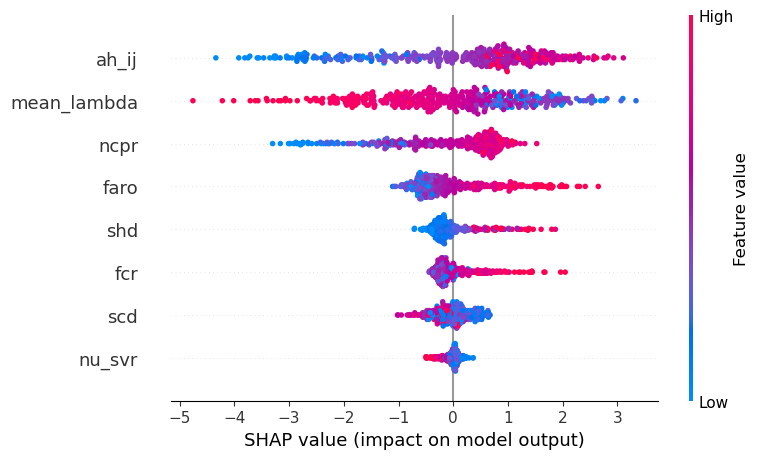

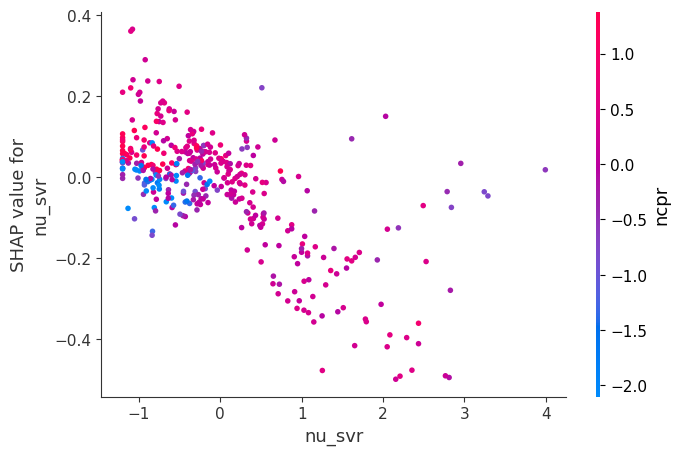

In [77]:
# find relationship of features and the whole 137 samples (delta_Rg)
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X_total)
shap_values = explainer(X_total)

# Extract feature names 
feature_names = ['nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij']  
X_total_df = pd.DataFrame(X_total, columns=feature_names)# Convert to DataFrame for better handling
print(X_total_df)
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_total, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_total_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)

13/13 [==============================] - 0s 356us/step


Using 389 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/389 [00:00<?, ?it/s]

3088/3088 [==============================] - 1s 221us/step


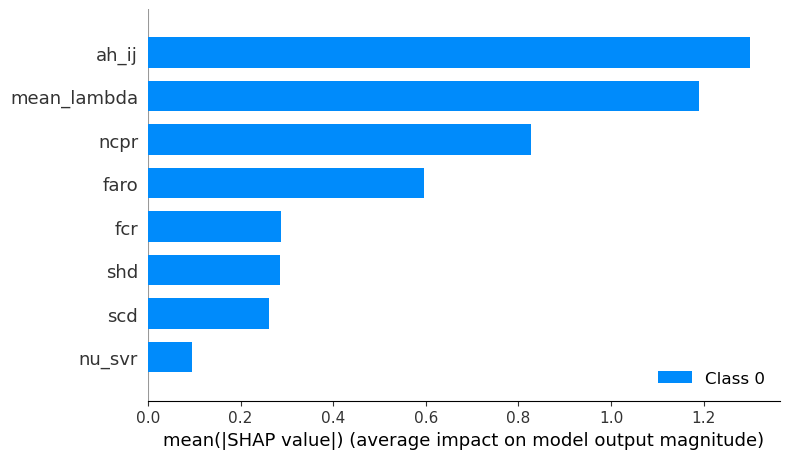

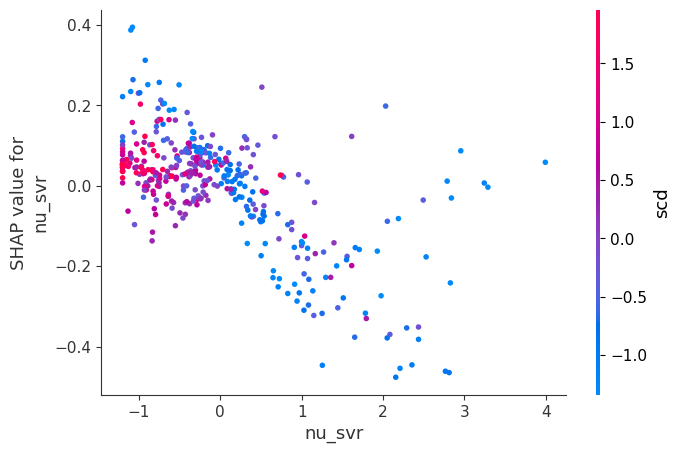

In [78]:
# to have fixed random_state so always get same Shap results and plots thankGOD!
import shap
import matplotlib.pyplot as plt



# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict, X_total, random_state=42)
shap_values = explainer.shap_values(X_total)

# Extract feature names 
feature_names = ['nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij']  
X_total_df = pd.DataFrame(X_total, columns=feature_names)# Convert to DataFrame for better handling
#print(X_test_dRg_df)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_total, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values[0],  # SHAP values for the test dataset
    features=X_total_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)

### ThankGOD! now test our model on 26 sampls of IDRome10

In [276]:
# Apply the same scaler to the smaller 64-sample dataset
X_IDRome10 = scaler.transform(X_IDRome10)

X has feature names, but StandardScaler was fitted without feature names


In [277]:


# Predict on the 64-sample dataset
y_pred_nn = model.predict(X_IDRome10)
#y_pred_nn = model.predict(X_test_tensor)


# Calculate MSE and R-squared for dataset

# to calc RMSD we need 1D of y_pred_nn
y_pred_nn_1d = y_pred_nn.reshape(-1)

mse_nn = mean_squared_error(y_IDRome10, y_pred_nn_1d)
r2_nn = r2_score(y_IDRome10, y_pred_nn_1d)
# thankGOD! correct formula for RMSD
rmsd_nn=np.sqrt(((y_IDRome10 - y_pred_nn_1d)**2).mean())


print("Neural Network MSE on test dataset:", mse_nn)
print("Neural Network R-squared on test dataset:", r2_nn)
print("Neural Network RMSD on test dataset:", rmsd_nn)

1/1 [==============================] - 0s 8ms/step
Neural Network MSE on test dataset: 0.6571072403109415
Neural Network R-squared on test dataset: 0.848243796355439
Neural Network RMSD on test dataset: 0.8106215148334897


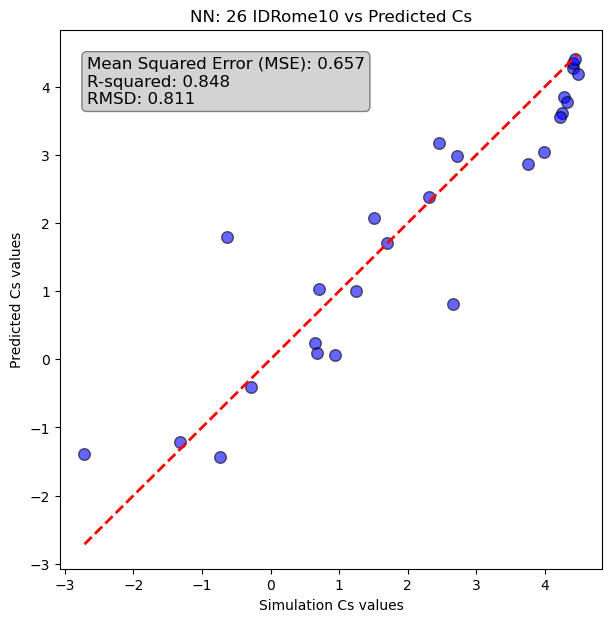

In [43]:
plt.figure(figsize=(7, 7))
plt.scatter(y_IDRome10, y_pred_nn, color='blue', edgecolor='k', alpha=0.6, s=70)
plt.plot([y_IDRome10.min(), y_IDRome10.max()], [y_IDRome10.min(), y_IDRome10.max()], 'r--', lw=2)
plt.xlabel('Simulation Cs values')
plt.ylabel('Predicted Cs values')
plt.title('NN: 26 IDRome10 vs Predicted Cs')

# Display MSE and R-squared inside the plot
text_str = f'Mean Squared Error (MSE): {mse_nn:.3f}\nR-squared: {r2_nn:.3f}\nRMSD: {rmsd_nn:.3f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'))

plt.show()

### ThankGOD! now test our model on 15 experimental sampls with 8 features 

In [278]:
# Apply the same scaler to the smaller 64-sample dataset
X_exp = scaler.transform(X_exp)

X has feature names, but StandardScaler was fitted without feature names


In [279]:
# Predict on the exp dataset
y_pred_nn = model.predict(X_exp)
#y_pred_nn = model.predict(X_test_tensor)


# Calculate MSE and R-squared for dataset

# to calc RMSD we need 1D of y_pred_nn
y_pred_nn_1d = y_pred_nn.reshape(-1)

mse_nn = mean_squared_error(y_exp, y_pred_nn_1d)
r2_nn = r2_score(y_exp, y_pred_nn_1d)
# thankGOD! correct formula for RMSD
rmsd_nn=np.sqrt(((y_exp - y_pred_nn_1d)**2).mean())


print("Neural Network MSE on test dataset:", mse_nn)
print("Neural Network R-squared on test dataset:", r2_nn)
print("Neural Network RMSD on test dataset:", rmsd_nn)

1/1 [==============================] - 0s 8ms/step
Neural Network MSE on test dataset: 0.27272834561822973
Neural Network R-squared on test dataset: 0.8530811935671478
Neural Network RMSD on test dataset: 0.5222339950809691


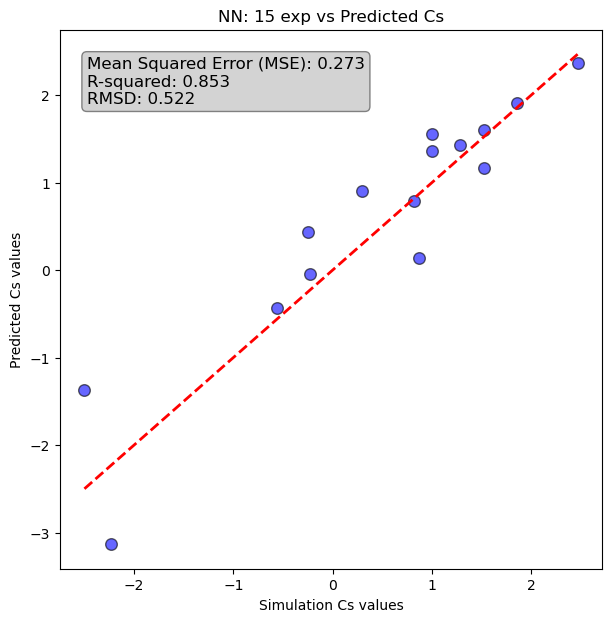

In [45]:
plt.figure(figsize=(7, 7))
plt.scatter(y_exp, y_pred_nn, color='blue', edgecolor='k', alpha=0.6, s=70)
plt.plot([y_exp.min(), y_exp.max()], [y_exp.min(), y_exp.max()], 'r--', lw=2)
plt.xlabel('Simulation Cs values')
plt.ylabel('Predicted Cs values')
plt.title('NN: 15 exp vs Predicted Cs')

# Display MSE and R-squared inside the plot
text_str = f'Mean Squared Error (MSE): {mse_nn:.3f}\nR-squared: {r2_nn:.3f}\nRMSD: {rmsd_nn:.3f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'))

plt.show()

      nu_svr      faro  mean_lambda       shd       scd       fcr      ncpr  \
0   0.816462  1.904545     1.439749 -0.155947 -1.027819  0.430920 -0.092643   
1   0.816462  1.761677     1.313479 -0.155947 -1.027819  0.430920 -0.022155   
2   0.816462  1.814313     1.360355 -0.155947 -1.027819  0.430920 -0.048107   
3   0.816462  1.266497     0.887992 -0.155947 -1.027819  0.430920  0.207898   
4  -0.209373  0.858973     0.814163 -0.221270 -0.126291  0.130274 -0.009147   
5  -0.237262  0.837006     0.738870 -0.221837 -0.099451  0.050138  0.019068   
6  -0.209373  0.858973     0.790516 -0.367074 -0.126291  0.130274 -1.272108   
7   0.797816  1.457829     1.009160 -0.137398 -1.038558  0.505870  0.222604   
8   0.816462  1.100492     0.740569 -0.155947 -1.027819  0.430920  0.282638   
9   0.816462  0.934488     0.591651 -0.155947 -1.027819  0.430920  0.355731   
10  0.816462  1.401793     1.007524 -0.155947 -1.027819  0.430920  0.145655   
11  0.816462  1.289367     0.913897 -0.155947 -1.027

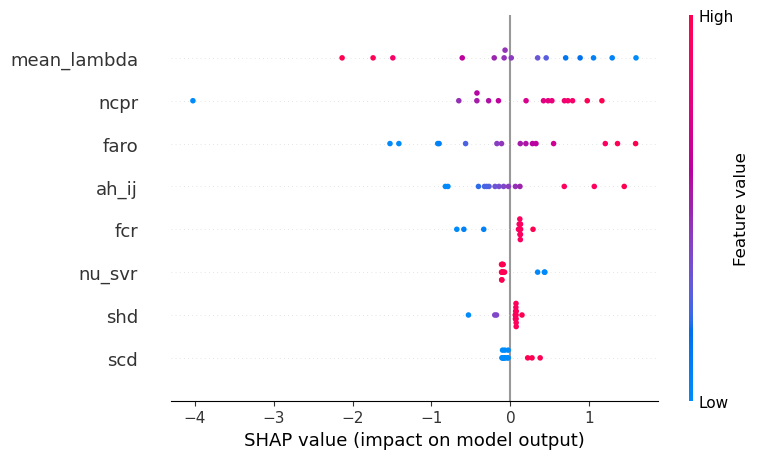

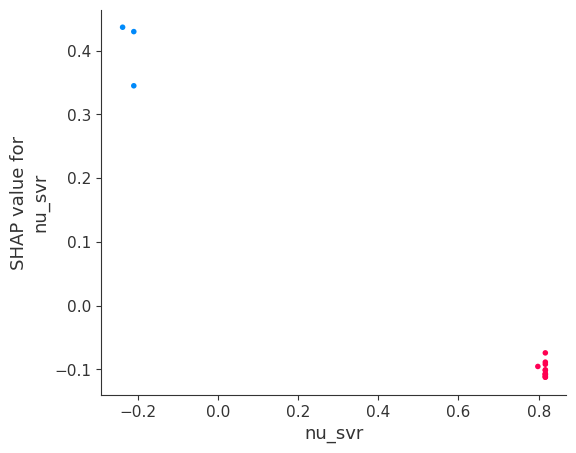

In [29]:
# find relationship of features and 15 exp samples (delta_Cs)
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X_exp)
shap_values = explainer(X_exp)

# Extract feature names 
feature_names = ['nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij']  
X_exp_df = pd.DataFrame(X_exp, columns=feature_names)# Convert to DataFrame for better handling
print(X_exp_df)
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_exp, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_exp_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)

# delta Cs

In [280]:
# thank GOD we agian read the exp data bc we want to have X_exp before fit_transform
df = pd.read_csv('df_prots_ORE.csv', usecols=['exp_logcdil_mgml', 'nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij'])
#ah_ij is delta H pair

#since there is some missing in data points of df_training(10 features of 35 protein sample) !!!!
# I have to clean the data frame 
df_cleaned = df.dropna()
#df_cleaned = pd.DataFrame(df.dropna(), columns = df.columns) 


# Separate the target (Cs or cdil) and features
X_exp = df_cleaned .drop(columns=['exp_logcdil_mgml']) # Features (all columns except 'Rg')
y_exp= df_cleaned ['exp_logcdil_mgml']  # Target (only the 'Rg' column)


print(X_exp.shape,'', y_exp.shape)

(15, 8)  (15,)


In [281]:
#Clear the Session: If you’re running the script multiple times in the same session (e.g., in Jupyter), 
#clear TensorFlow's computational graph between runs to avoid accumulation:
clear_session()

In [282]:
# Set random seed for reproducibility. Always will get same result. but if I do not use it, every time that I run I got slightly different results
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [283]:
#To load our trained model thankGOD!
Cs_model=joblib.load('NN_model.joblib')
y_pred_nn = Cs_model.predict(X_exp)

1/1 [==============================] - 0s 29ms/step


In [284]:
Cs_exp = np.array (y_exp)
Cs_pred = np.array (y_pred_nn)

In [285]:
#delta_Cs = Cs_exp - Cs_pred
delta_Cs=[]

for i in range (len(y_pred_nn)):
    #print (delta_Rg[i])
    delta_Cs.append( Cs_exp[i]- Cs_pred[i] )
#print (delta_Rg.min())

In [286]:
delta_Cs = scaler.fit_transform(delta_Cs)
delta_Cs

array([[-2.50982379],
       [ 0.31835722],
       [-0.88497774],
       [ 0.46494975],
       [ 0.04850596],
       [ 1.53968411],
       [-1.22746786],
       [-0.05342429],
       [ 0.88829383],
       [ 1.3280858 ],
       [ 0.13862698],
       [ 0.69299143],
       [-0.30988081],
       [-0.70432864],
       [ 0.27040807]])

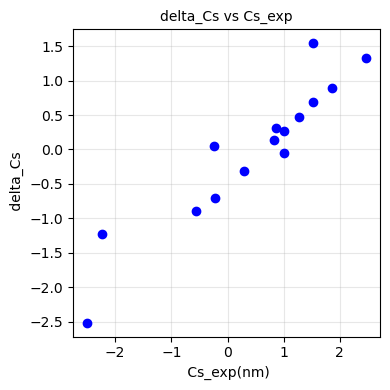

In [287]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(4,4))


ax.plot(Cs_exp, delta_Cs,'o',color='b')#,fillstyle='none')


ax.set(xlabel=f' Cs_exp(nm)', ylabel=f' delta_Cs')
ax.set_title('delta_Cs vs Cs_exp',fontsize=10)
ax.grid(alpha=0.3)

fig.tight_layout()

# NN for delta Cs

## ThankGOD! train the model on delta Rg

### Step 3: Define the Neural Network Model with cross validation (thankGOD! one leave out cross validation)

In [77]:
# Standardize the data
scaler = StandardScaler()

# for X_train with shape (15,8) we fit a unigue transform
X_train = scaler.fit_transform(X_train)


#thankGOD! for exp sample which is in same shape of train sampe we do not fit transform
X_exp = scaler.transform(X_exp)

# for delta_Cs which has shape (15,) we fit a unique transform
#delta_Cs = scaler.fit_transform(delta_Cs)

X has feature names, but StandardScaler was fitted without feature names


In [197]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [198]:
#Modified Code for LOOCV

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import LeaveOneOut
import joblib

rmsd_nn=0
rmsd_as_list=[rmsd_nn]
#rmsd_nn=np.sqrt(((delta_Cs - pred_dCs_1d)**2).mean())

# Define the Keras model
def create_model():
    model = Sequential([
        Dense(64, activation='tanh', input_dim=X_exp.shape[1]),
        Dropout(0.01),
        Dense(16, activation='tanh'),
        Dropout(0.01),
        Dense(8, activation='tanh'),
        Dropout(0.01),
        Dense(8, activation='tanh'),
        Dropout(0.01),
        #Dense(8, activation='tanh'),
        #Dropout(0.01),
        Dense(1, activation='linear')
    ])
    #model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer=Adam(learning_rate=0.003), loss='mean_squared_error')
    return model

# Define the early stopping callback
    early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Cross-validation setup
#kf = KFold(n_splits=10, shuffle=True, random_state=42)
loo = LeaveOneOut()
mse_scores = []
r2_scores = []

all_y_true = []
all_y_pred = []

# Perform cross-validation
for train_index, val_index in loo.split(X_exp):
    # Split the data
    X_train, X_val = X_exp[train_index], X_exp[val_index]
    y_train, y_val = delta_Cs[train_index], delta_Cs[val_index]

    # Create a new instance of the model
    model = create_model()
 
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=1, callbacks=[early_stopping], verbose=1)
    #history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=1, verbose=1)


    # Predict on the test set
    pred_dCs = model.predict(X_exp)

    
        # Append true and predicted values
    all_y_true.extend(delta_Cs)
    all_y_pred.extend(pred_dCs.flatten())  # Flatten predictions
    
    mse = mean_squared_error(delta_Cs, pred_dCs)
    mse_scores.append(mse)

      # Calculate R-squared
    r2 = r2_score(delta_Cs, pred_dCs)
    r2_scores.append(r2)


    # to calc RMSD we need 1D of y_pred_nn
    pred_dCs_1d = pred_dCs.reshape(-1)

    rmsd_nn=np.sqrt(((delta_Cs - pred_dCs_1d)**2).mean())
    
    rmsd_as_list.append(rmsd_nn)
    
# to save the trained model
joblib.dump(model, 'model_dCs.joblib')



Epoch 1/100
14/14 [==============================] - 0s 5ms/step - loss: 0.6472 - val_loss: 1.7992
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.3737 - val_loss: 1.4982
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2123 - val_loss: 2.8465
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2111 - val_loss: 1.7667
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2213 - val_loss: 1.9686
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 1.8334
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1456 - val_loss: 2.0022
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1411 - val_loss: 1.7068
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1597 - val_loss: 1.5671
Epoch 10/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1327 - val_loss: 1.6702
Epoch 11/

['model_dCs.joblib']

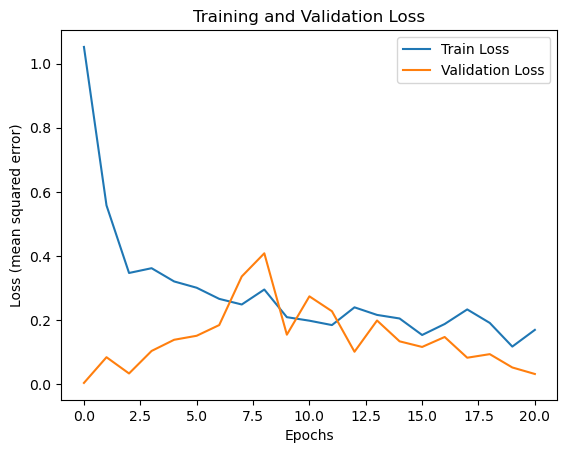

In [199]:

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (mean squared error)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [200]:
rmsd_as_list

[0,
 1.354332505597452,
 1.1970426444862055,
 1.2521842860485919,
 1.4000117679729165,
 1.1384777902580419,
 1.3689189395558872,
 1.3737973761974391,
 1.3799109051079652,
 1.3664138006489555,
 1.4346292082662715,
 1.4371290481360641,
 1.2944949617338004,
 1.3800975617685645,
 1.2308687214308054,
 1.1408935453277587]

Cross-validated MSE scores: [0.14116204999623477, 0.39175933045233774, 0.23476154871766336, 0.00629447182265935, 0.4559792074174192, 0.10032140276339922, 0.06257080100528663, 0.027415535450368348, 0.19116778551246008, 0.053102045988705486, 0.027744080955647368, 0.323766733278632, 0.302781511929152, 0.29382898093789467, 0.46534397615804024]
Mean MSE: 0.2052, Std Dev: 0.1547
Cross-validated R-squared scores: [0.8588379500037653, 0.6082406695476624, 0.7652384512823367, 0.9937055281773407, 0.544020792582581, 0.8996785972366008, 0.9374291989947134, 0.9725844645496317, 0.80883221448754, 0.9468979540112945, 0.9722559190443526, 0.6762332667213682, 0.6972184880708481, 0.7061710190621054, 0.53465602384196]
Mean R-squared: 0.7948, Std Dev: 0.1547
Cross-validated rmsd scores: [0, 1.354332505597452, 1.1970426444862055, 1.2521842860485919, 1.4000117679729165, 1.1384777902580419, 1.3689189395558872, 1.3737973761974391, 1.3799109051079652, 1.3664138006489555, 1.4346292082662715, 1.4371290481360641, 1.

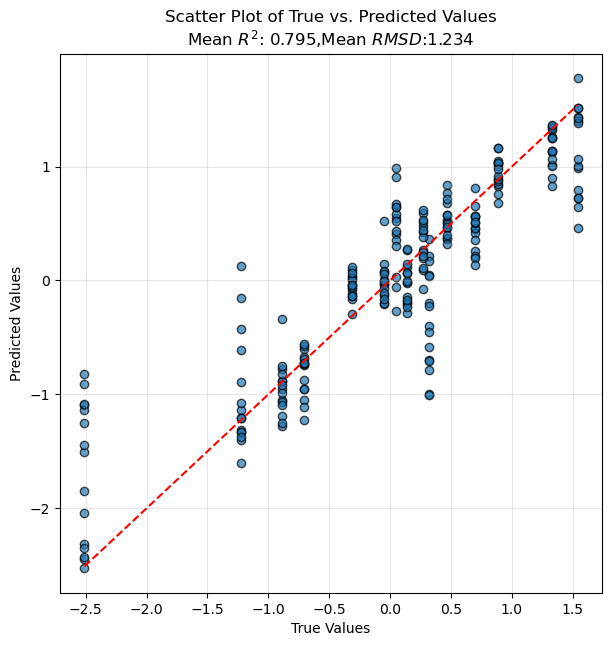

In [201]:
# Calculate the mean and standard deviation of the MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

mean_rmsd = np.mean(rmsd_as_list)
std_rmsd = np.std(rmsd_as_list)

# Output results
print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Mean MSE: {mean_mse:.4f}, Std Dev: {std_mse:.4f}")
print(f"Cross-validated R-squared scores: {r2_scores}")
print(f"Mean R-squared: {mean_r2:.4f}, Std Dev: {std_r2:.4f}")
print(f"Cross-validated rmsd scores: {rmsd_as_list}")
print(f"Mean RMSD: {mean_rmsd:.4f}, Std Dev: {std_rmsd:.4f}")



# Create scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(all_y_true, all_y_pred, alpha=0.7, edgecolor='k')
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], color='red', linestyle='--')  # Diagonal line
plt.title(f"Scatter Plot of True vs. Predicted Values\nMean $R^2$: {mean_r2:.3f},Mean $RMSD$:{mean_rmsd:.3f}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(alpha=0.3)
plt.show()

## determine the effect of features

### 2. SHAP (SHapley Additive exPlanations)

      nu_svr      faro  mean_lambda       shd       scd       fcr      ncpr  \
0   0.526143  1.675886     1.873938  0.403310 -0.519545  0.464334 -0.283012   
1   0.526143  1.268216     1.356156  0.403310 -0.519545  0.464334 -0.097016   
2   0.526143  1.418410     1.548374  0.403310 -0.519545  0.464334 -0.165497   
3   0.526143 -0.144758    -0.388585  0.403310 -0.519545  0.464334  0.510016   
4  -1.892618 -1.307611    -0.691327 -0.735796  1.890649 -1.690169 -0.062695   
5  -1.958375 -1.370292    -1.000075 -0.745701  1.962406 -2.264444  0.011755   
6  -1.892618 -1.307611    -0.788293 -3.278376  1.890649 -1.690169 -3.395228   
7   0.482178  0.401200     0.108274  0.726772 -0.548254  1.001446  0.548819   
8   0.526143 -0.618445    -0.993106  0.403310 -0.519545  0.464334  0.707229   
9   0.526143 -1.092133    -1.603756  0.403310 -0.519545  0.464334  0.900098   
10  0.526143  0.241303     0.101563  0.403310 -0.519545  0.464334  0.345778   
11  0.526143 -0.079500    -0.282362  0.403310 -0.519

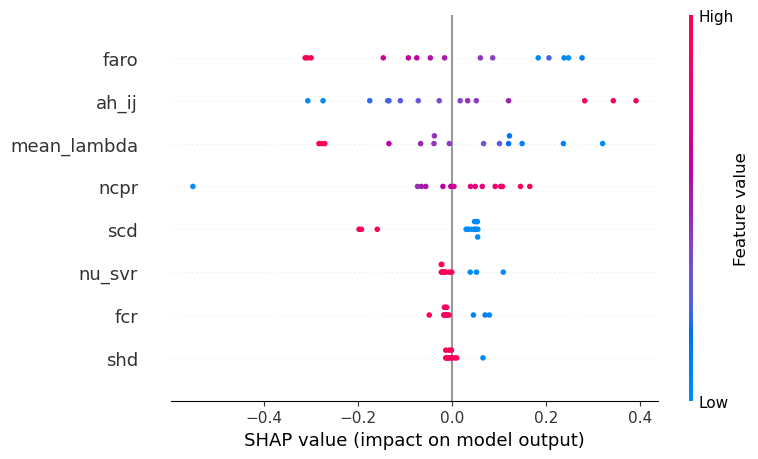

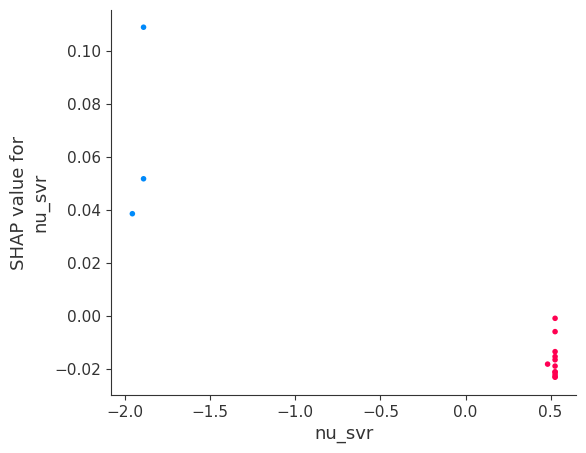

In [203]:
# find relationship of features and the whole 137 samples (delta_Rg)
import shap
import matplotlib.pyplot as plt

# Load the saved model
model_dCs = joblib.load('model_dCs.joblib')

# Create a SHAP explainer
explainer = shap.Explainer(model_dCs, X_exp)
shap_values = explainer(X_exp)

# Extract feature names 
feature_names = ['nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij']  
X_exp_df = pd.DataFrame(X_exp, columns=feature_names)# Convert to DataFrame for better handling
print(X_exp_df)
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_exp, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_exp_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)

In [ ]:
# effect of each feature
# Create dependence plot for a single feature (e.g., 'f1')
for i, feature in enumerate(feature_names):
    print(f"Generating dependence plot for: {feature}")
    shap.dependence_plot(
        i,  # Feature index
        shap_values.values,
        X_exp_df,
        feature_names=feature_names
    )

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/15 [00:00<?, ?it/s]

120/120 [==============================] - 0s 459us/step


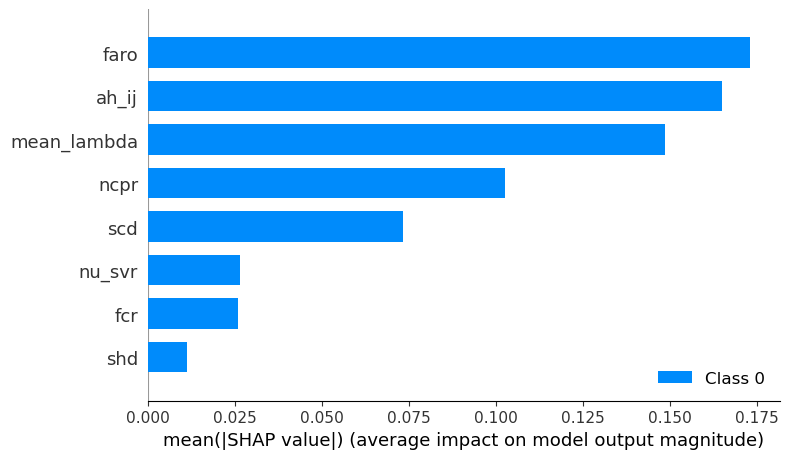

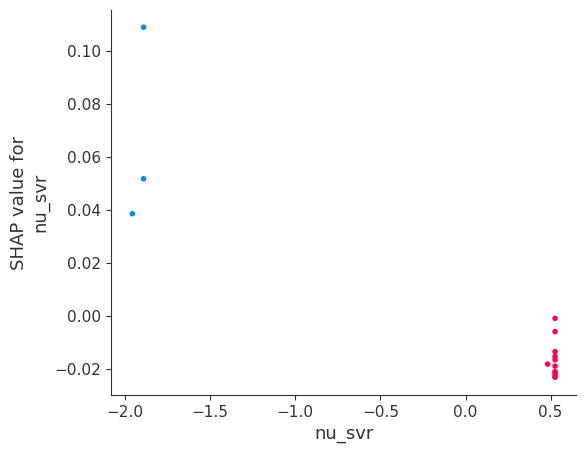

In [204]:
# to have fixed random_state so always get same Shap results and plots thankGOD!
import shap
import matplotlib.pyplot as plt



# Create a SHAP explainer
explainer = shap.KernelExplainer(model_dCs.predict, X_exp, random_state=42)
shap_values = explainer.shap_values(X_exp)

# Extract feature names 
feature_names = ['nu_svr', 'faro','mean_lambda', 'shd', 'scd', 'fcr', 'ncpr', 'ah_ij']  
X_exp_df = pd.DataFrame(X_exp, columns=feature_names)# Convert to DataFrame for better handling
#print(X_test_dRg_df)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_exp, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values[0],  # SHAP values for the test dataset
    features=X_exp_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)